In [22]:

#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.

#
#  Authored by:    Tommi Heikkilä (LUT)
#  Review by:      Margaret Duff (STFC-UKRI)


In [23]:

import cil
print(f"Using CIL version {cil.__version__}")

Using CIL version 24.2.0


# Controlled Wavelet Sparsity using callbacks (2D data)

### 2D laboratory micro-CT, fan-beam data of a walnut

This example uses the walnut dataset `Data328.mat` from https://doi.org/10.5281/zenodo.1254206 :

- https://zenodo.org/records/1254206/files/Data328.mat?download=1

If running locally please download the data and update the 'path' variable below.


In [24]:
path = './data'

Set the logging level

In [25]:
import logging
logger = logging.getLogger('dxchange')
logger.setLevel(logging.ERROR)

First import all of the modules we will need:

In [26]:
import os
import numpy as np

# cil imports
from cil.framework import ImageData, ImageGeometry
from cil.framework import AcquisitionGeometry, AcquisitionData

from cil.optimisation.functions import LeastSquares, L1Sparsity, ScaledFunction
from cil.optimisation.operators import WaveletOperator
from cil.optimisation.algorithms import FISTA

from cil.plugins.astra import ProjectionOperator

from cil.utilities.display import show2D, show_geometry

import scipy.io

Load the 2D fan-beam sinogram of walnut:

In [27]:
filename = os.path.join(path, "Data328.mat")

matdata = scipy.io.loadmat(filename)
sinogram = np.float32(matdata["m"].transpose()) # Matlab is column-major, numpy is row-major
num_angles, num_pixels = sinogram.shape

## Create geometry

We have to manually set the values for the correct geometry. These can be found in the [documentation](https://arxiv.org/abs/1502.04064) of the data.

In [28]:
# Acquisition geometry parameters
SOD = 110 # Source-Origin-distance
print(f'SOD: {SOD:.3f} mm')
SDD = 300 # Source-Detector-distance
print(f'SDD: {SDD:.3f} mm')
ODD = SDD - SOD # Origin-detector-distance
print(f'ODD: {ODD:.3f} mm')
pixelSize = 114.8 / num_pixels # Detector pixel width after binning
print(f'Detector pixel size: {pixelSize:.3f} mm')

angles = np.linspace(0., 360., 120, endpoint=False)

SOD: 110.000 mm
SDD: 300.000 mm
ODD: 190.000 mm
Detector pixel size: 0.350 mm


In [29]:
ag = AcquisitionGeometry.create_Cone2D([0,-SOD], [0,ODD], units='mm',detector_direction_x=[1, 0])
ag.set_panel(num_pixels, pixel_size=pixelSize, origin='bottom-left')
ag.set_angles(-angles)
ag.set_labels(('angle','horizontal'))
print(ag)

2D Cone-beam tomography
System configuration:
	Source position: [   0., -110.]
	Rotation axis position: [0., 0.]
	Detector position: [  0., 190.]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [328   1]
	Pixel size: [0.35 0.35]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 120
	Angles 0-9 in degrees: [ -0.,  -3.,  -6.,  -9., -12., -15., -18., -21., -24., -27.]
	Angles 110-119 in degrees: [-330., -333., -336., -339., -342., -345., -348., -351., -354., -357.]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: mm


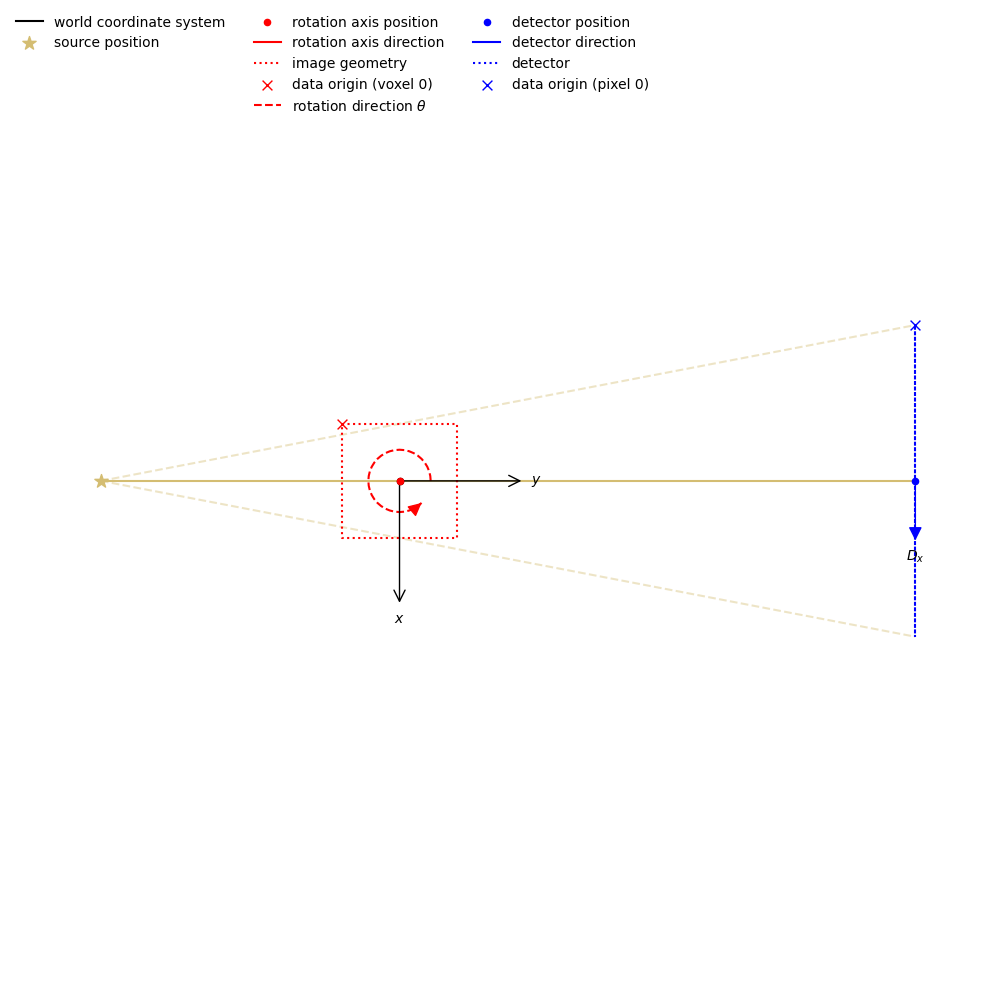

In [30]:
show_geometry(ag);

### Image geometry and data

Notice in particular how the `voxel_size` (or image pixel size) matches the reported value of 0.128 mm.

Number of channels: 1
channel_spacing: 1.0
voxel_num : x327,y327
voxel_size : x0.12833333333333333,y0.12833333333333333
center : x0,y0



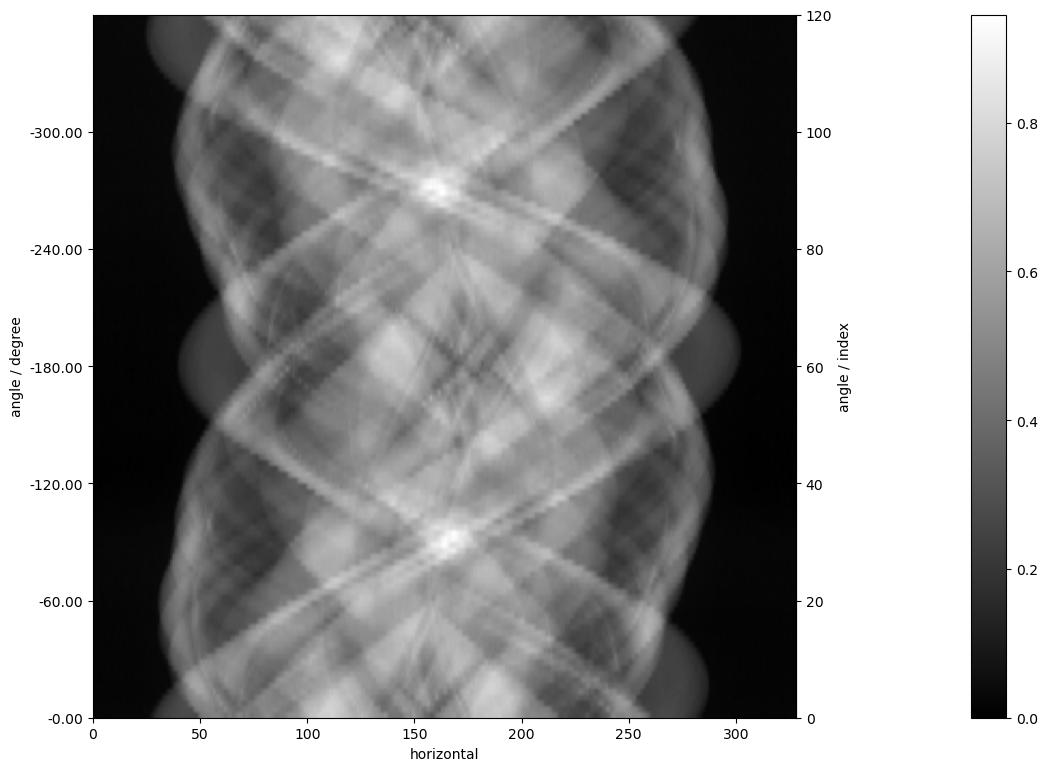

In [31]:
# Setup image geometry
n = num_pixels - 1
ig = ag.get_ImageGeometry()
ig.voxel_num_x = n
ig.voxel_num_y = n
print(ig)

# Setup data
data = AcquisitionData(sinogram, deep_copy=False, geometry=ag)
show2D(data);

## Reconstructions

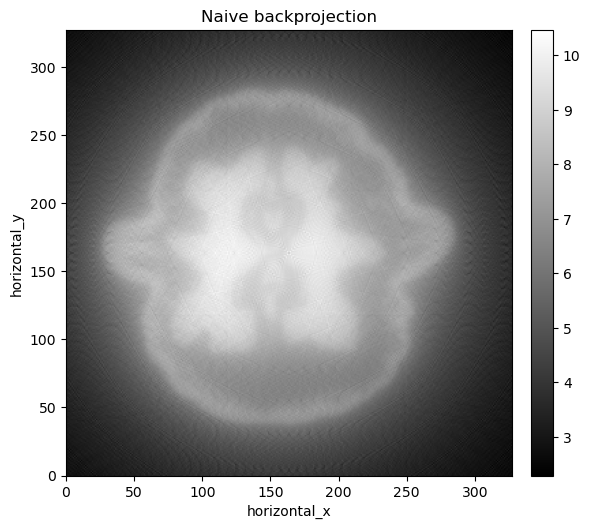

In [32]:
A = ProjectionOperator(ig, ag, 'cpu')

x_bp = A.adjoint(data) # Simple backprojection
show2D(x_bp, size=(10,10), title="Naive backprojection");

# Wavelet based regularization

Classical approach in imaging problems (such as CT, denoising, etc.) is to try represent the key information about the solution using a wavelet basis. By construction a relatively sparse solution (i.e. only few nonzero components) should suffice, as opposed to pixel-based representation.

In short, we have the least squares data mismatch term of form
$$ \frac{1}{2} \| A f - m_\delta \|_2^2,$$
where $A$ is the forward operator, $m_\delta$ is the noisy data and $f$ is the unknown solution. 
Then we add a regularization term of the form
$$ \alpha \| W(f) \|_1 = \alpha \sum_{j,k} | c(f)_{j,k} |, $$
where $\alpha > 0$ is the regularization term (balacing our trust in data and need in regularization) 
and $W$ is the Discrete Wavelet Transform operator which decomposes any input $f$ (signal, image or volume) into a sequence of coefficients $c(f)_{j,k}$ of varying scale ($j \in \mathbb{N}$) and location ($k \in \mathbb{Z}^d$), such that
$$ f = \sum_{j,k} c(f)_{j,k} \psi_{j,k}.$$

### Wavelet transform

Classical choice is one of the orthogonal wavelets of [Ingrid Daubechies](https://en.wikipedia.org/wiki/Ingrid_Daubechies), usually distinguished by their smoothness properties. For example the Daubechies-2 wavelets always give continuous approximations.

In [33]:
wname = 'db2'
level = 4

W = WaveletOperator(ig, level=level, wname=wname)

### Fast Iterative Soft Thresholding Algorithm (FISTA)
Equally classic choice of minimization algrorithm in the (Fast) Iterative Soft Thresholding Algorithm (ISTA), originally developed for wavelet-based denoising in  
> Daubechies, I, Defrise, M, & De Mol, C..  
*An iterative thresholding algorithm for linear inverse problems with a sparsity constraint.*  
Communications on Pure and Applied Mathematics: A Journal Issued by the Courant Institute of Mathematical Sciences 57.11 (2004): 1413-1457.

Although we will run the accelerated version.

In [34]:
f = LeastSquares(A, data)
g = L1Sparsity(W)

tau = 1e-5  # Regularization parameter

fista = FISTA(initial=ig.allocate(0), f=f, g=tau*g)

Let's run arbitrary number of iterations (200)

In [35]:
fista.run(200)

  0%|          | 0/200 [00:00<?, ?it/s]

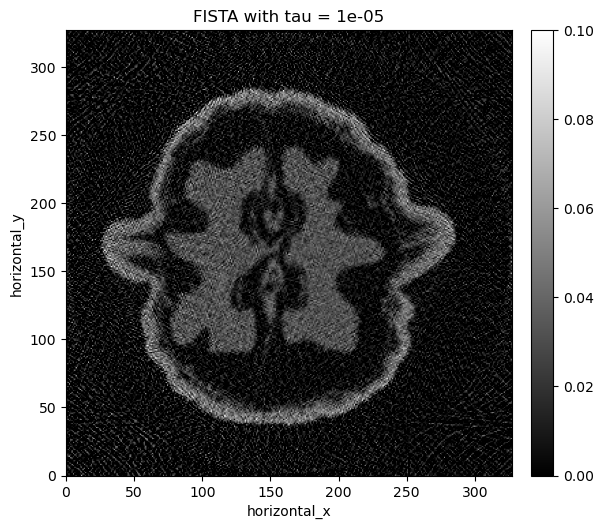

In [36]:
x_fista = fista.get_output()
show2D(x_fista, size=(10,10), fix_range=(0,0.1), title=f"FISTA with {tau = }");

Looks okay but how do we know the choice of regularization parameter was good? Could we get a better result with another value? Do we have the patience to try out dozens or even hundreds of values?

## Automated Controlled Sparsity

We follow the automated tuning strategy as introduced in  
> Purisha, Z., Rimpeläinen, J., Bubba, T., & Siltanen, S. (2017).  
*Controlled wavelet domain sparsity for x-ray tomography*.  
Measurement Science and Technology, 29(1), 014002.  
[DOI:10.1088/1361-6501/aa9260](https://doi.org/10.1088/1361-6501/aa9260)

We'll try to implement it as a `StepSizeRule` and `callback`. However we are NOT actually changing the `step_size` (which is based on the Lipschitz constant of the data mistmatch term) but the regularization parameter `tau`. However, we can update it every iterate by using `StepSizeRule` (in fact we could pass it an actual `StepSizeRule` to perform but let's just stick with constant value for now).

In [37]:
from SparsityControl import ControlledSparsity, DesiredSparsity

In [38]:
reg_weight = 1e-2
# Automated tuning of regularization parameter
sparsity_ctrl = ControlledSparsity(desired_sparsity=0.3)
fista_controlled = FISTA(initial=ig.allocate(0), f=f, g=reg_weight*g, step_size=sparsity_ctrl, max_iteration=500)

In [39]:
# Sparsity based stopping rule
sparsity_stop = DesiredSparsity(print_stuff=2, rel_change_tol=5e-4)

In [40]:
fista_controlled.run(500, callbacks=[sparsity_stop])

Iteration : 5 | Current sparsity: 0.973 | Regularization param.: 9.56e-03 | Desired sparsity: 0.300 | Difference: 0.673 | Beta: 5.90e-05 | Relative change: 8.82e-02
Iteration : 10 | Current sparsity: 0.965 | Regularization param.: 9.76e-03 | Desired sparsity: 0.300 | Difference: 0.665 | Beta: 5.90e-05 | Relative change: 5.13e-02
Iteration : 15 | Current sparsity: 0.950 | Regularization param.: 9.95e-03 | Desired sparsity: 0.300 | Difference: 0.650 | Beta: 5.90e-05 | Relative change: 3.04e-02
Iteration : 20 | Current sparsity: 0.931 | Regularization param.: 1.01e-02 | Desired sparsity: 0.300 | Difference: 0.631 | Beta: 5.90e-05 | Relative change: 1.78e-02
Iteration : 25 | Current sparsity: 0.908 | Regularization param.: 1.03e-02 | Desired sparsity: 0.300 | Difference: 0.608 | Beta: 5.90e-05 | Relative change: 1.17e-02
Iteration : 30 | Current sparsity: 0.884 | Regularization param.: 1.05e-02 | Desired sparsity: 0.300 | Difference: 0.584 | Beta: 5.90e-05 | Relative change: 8.16e-03
Itera

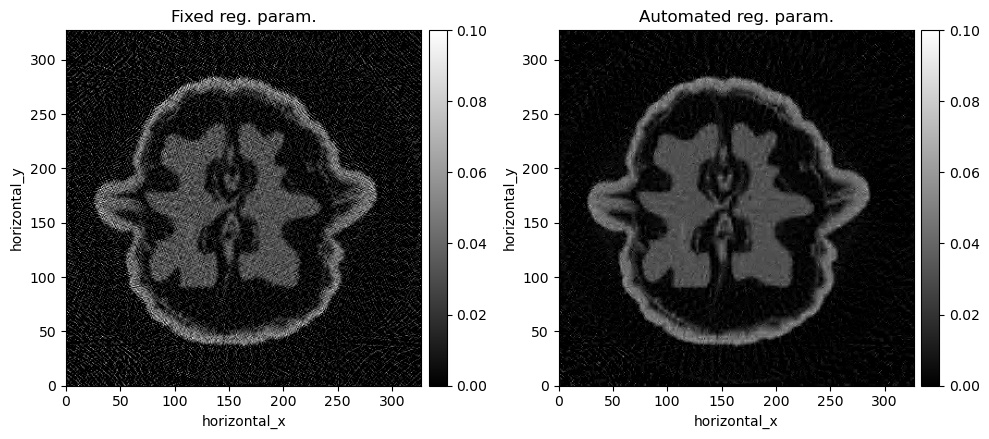

In [41]:
x_controlled = fista_controlled.solution
show2D([x_fista, x_controlled], title=["Fixed reg. param.", "Automated reg. param."], fix_range=(0,0.1), size=(10,20));

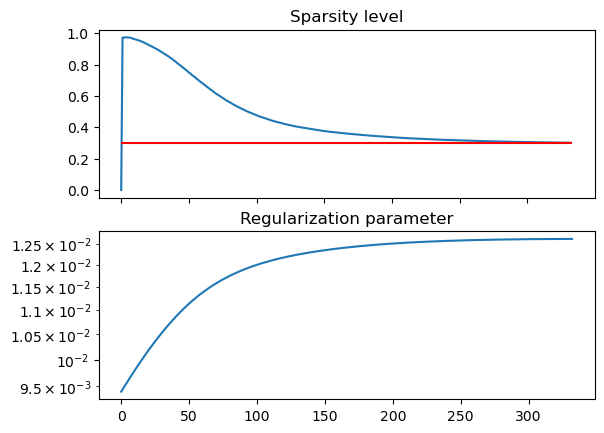

In [42]:
import matplotlib.pyplot as plt

N = fista_controlled.iterations[-1]
fig, ax = plt.subplots(2)
ax[0].plot(sparsity_ctrl.sparsity_vals)
ax[0].hlines(sparsity_ctrl.desired_sparsity, xmin=0, xmax=N, colors='r');
ax[0].set_title("Sparsity level")

ax[1].semilogy(sparsity_ctrl.reg_param_vals)
ax[1].set_title("Regularization parameter")
for a in ax.flat:
    a.label_outer()

### Limitations of the method

The method does not fully automate the choice of regularization parameter as the desired sparsity level and some of the tuning parameters still need to be chosen. 
However, chosing a good level of sparsity is much easier, the values are clearly bounded between 0 and 1 (corresponding to 0% and 100% of coefficients being "meaningful") and the tuning parameters mostly affect the speed on the method. 
Moreover, with bit of experience, it is relatively easy to tell early whether the choice will be good and restart the algorithm if needed.